# V-n Diagram

This section illustrates how to create a V-n diagram for the example airplane. This diagram relates airspeed to structural loads experienced by the airframe, which are later used for structural analysis. Essentially, it defines operating envelope for the airplane in terms of the maximum maneuvers and speeds. Refer to [FAR Part 23 Subpart C](https://www.ecfr.gov/current/title-14/chapter-I/subchapter-C/part-23/subpart-C) for regulations related to airplane structures.

<div style="width:90%; margin: auto;">

Parameter | Value | Source
--------- | :---: | :---:
Wing loading, $$W/S | 44 lbs/$\text{ft}^2$ | trade study
Wing area, S | 145 $\text{ft}^2$ | computed
Mean aerodynamic chord, $\bar{c}$ | 4.26 ft | computed
Max positive lift coefficient, $C_{L_{max^+}}$ | 1.44 | computed
Max negative lift coefficient, $C_{L_{max^-}}$ | -1.1 | computed
Max steady level airspeed, $V_H$ |  | Computed
</div>

Note that this diagram is created for clean configuration and aircraft is at MTOW.

The first step is to compute four different speeds:

1. 1g stall speed, $V_s$
2. design cruise speed, $V_c$
3. design diving speed, 
4. design maneuvering speed

Refer to lecture notes, Raymer section 14.3.1 and 14.3.2, and Roskam Part 5 section 4.2 for more details.

In [1]:
import nbimporter
from mtow import compute_takeoff_weight
from scipy.optimize import fsolve
import numpy as np

# From trade study
A = 9
wing_loading = 44 # lbs/sq ft
power_loading = 9.1 # lbs/hp

# Size the aircraft
MTOW, aircraft = compute_takeoff_weight(wing_loading, power_loading, A)

# Variables
Pmax_sealevel = aircraft.P_takeoff # hp
Pmax_cruise = aircraft.P_cruise # hp
rho_cruise = aircraft.rho_cruise # slugs/cu ft
rho_sealevel = aircraft.rho_sea_level # slugs/cu ft
prop_eff = aircraft.prop_eff_cruise
e = aircraft.e
S = aircraft.S # sq ft
CD0 = aircraft.CD0
CLmax = 1.44 # aircraft.CLmax

def compute_power(x, weight, S, CD0):
    """
        Function to compute drag for a given velocity
    """

    dyn_pressure = 0.5 * rho_cruise * x**2 # slugs/cu ft

    CL = weight / dyn_pressure / S

    CD = CD0 + CL**2/np.pi/A/e

    D = CD * dyn_pressure * S # lbs

    power = D * x / prop_eff / 550 # hp

    return power

# Equation which needs to be solved to find the velocity at max power
eqn = lambda x, weight, S, CD0: compute_power(x, weight, S, CD0) - Pmax_cruise

x0 = 350 # ft/s

VH = fsolve(eqn, x0=x0, args=(MTOW, S, CD0)).item() / 1.68781 # kts

print(f"Max speed at cruising altitude: {VH:.0f} kts")

# Compute equivalent air speed
compute_Ve = lambda x: (rho_cruise/rho_sealevel)**0.5 * x

Max speed at cruising altitude: 205 kts


## Load factor

In [2]:
nplus = 2.1 + 24000 / (MTOW + 10000)
nminus = -0.4*nplus

print(nplus,nminus)

3.5655205772716245 -1.42620823090865


In [3]:
stall_line = lambda V, CLmax: 0.5 * rho_cruise * V**2 * CLmax / wing_loading

Vstall = (wing_loading * 2 / rho_cruise / 1 / CLmax )**0.5 # ft/s

print(Vstall/1.688)

Va_pos = Vstall * nplus**0.5 # ft/s

V_pos_stall_line = np.linspace(0,Va_pos,100) 

pos_stall_line = stall_line(V_pos_stall_line, CLmax) # ft/s

print(Va_pos/1.688)

107.1443206662328
202.31618598316567


In [4]:
Vc = ( (28.6-33)*(wing_loading - 20)/80  + 33) * wing_loading**0.5

print(Vc/1.688)

124.49131914509368


In [6]:
Vd = ( (1.35-1.4)/80 * (wing_loading - 20) + 1.4 ) * Vc

print(Vd/1.688)

172.42047701595473


Text(0, 0.5, 'Load factor, $n$')

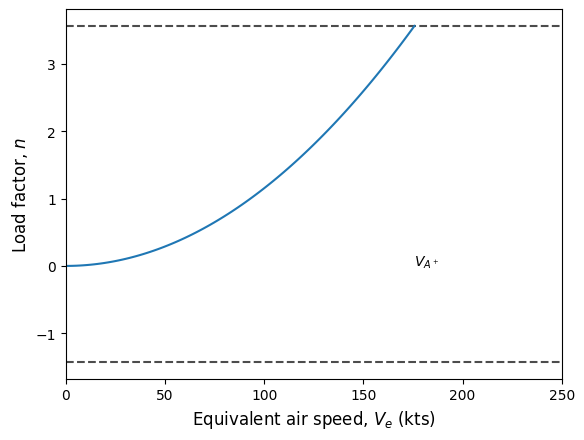

In [4]:
import matplotlib.pyplot as plt

fs = 12

fig, ax = plt.subplots()
ax.axhline(y=nplus, linestyle="--", color="k", alpha=0.7)
ax.axhline(y=nminus, linestyle="--", color="k", alpha=0.7)

ax.plot(compute_Ve(V_pos_stall_line)/1.688,pos_stall_line)

# Annotations
ax.annotate("$V_{A^+}$", (compute_Ve(Va_pos)/1.688,0))

# Asthetics
ax.set_xlim(left=0, right=250)
ax.set_xlabel("Equivalent air speed, $V_e$ (kts)", fontsize=fs)
ax.set_ylabel("Load factor, $n$", fontsize=fs)